<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Training-models" data-toc-modified-id="Training-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training models</a></span><ul class="toc-item"><li><span><a href="#Creating-features" data-toc-modified-id="Creating-features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Creating features</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForest</a></span></li></ul></li><li><span><a href="#Model-analysis" data-toc-modified-id="Model-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model analysis</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RandomForest</a></span></li></ul></li><li><span><a href="#Testing-the-Lightdm-model" data-toc-modified-id="Testing-the-Lightdm-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing the Lightdm model</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

#  Forecasting taxi orders

The company "Chetenkoe taxi" collected historical data on taxi orders at airports. To attract more drivers during peak load, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric in the test sample should be no more than 48.

You need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column (from English *number of orders*, "number of orders").

## Data preparation

Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

#new lib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('datasets/taxi.csv', 
                 index_col=[0],
                 parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df = df.resample('1H').sum()
df.sort_index(inplace=True)

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


After resampling, we received a dataset for 4416 rows, now we will start analyzing the received data

## Analysis

Let's check datetime for monotony

In [5]:
df.index.is_monotonic

/var/folders/4f/f3dd0ncx24gcgzrw3shqgs_00000gn/T/ipykernel_76839/2090065119.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

Plot the trend, seasonality and decomposition residues

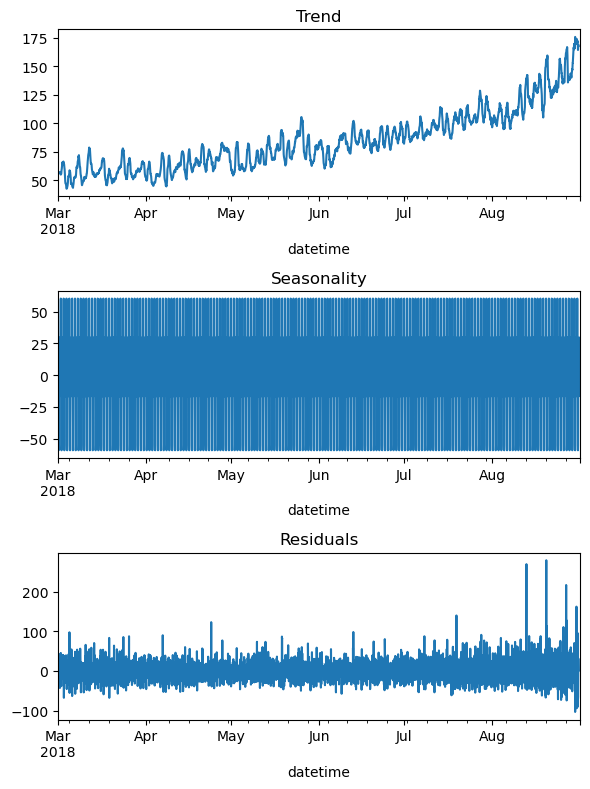

In [6]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

As can be seen from the graphs above, there is a positive trend of growth in the number of trips

Let's look at the seasonality chart on the weekly and three-day segments

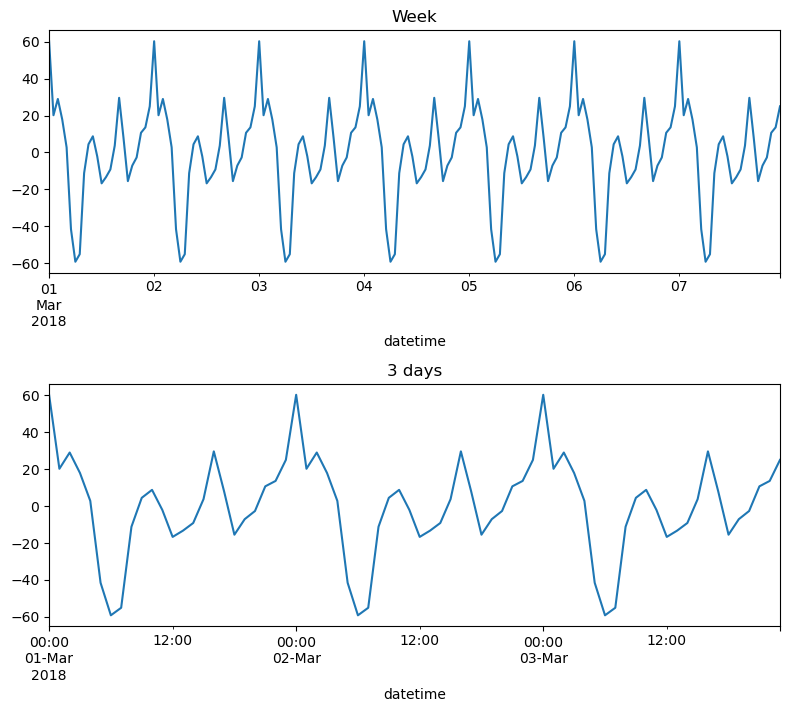

In [7]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.seasonal[:168].plot()
plt.title('Week')

plt.subplot(312)
decomposed.seasonal[:72].plot()
plt.title('3 days')
plt.tight_layout()

You can notice that most trips are made at noon (from 10:00 to 12:00), lunch (15:00) and midnight (00:00), the least trips are made at night (~6:00)

<AxesSubplot: >

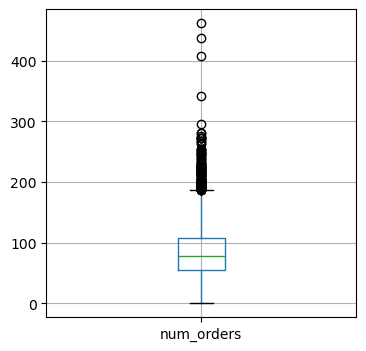

In [8]:
df.boxplot(figsize=(4, 4))

In [9]:
df.query('num_orders > 200').count()

num_orders    81
dtype: int64

Leaving outliers because it is impossible to prove their fallacy

## Training models

To solve the problem, we will use three machine learning models: Lightgdm, Cut Boost and Random Forest

Let's start by creating features

### Creating features

Let's create a *create_features* function that accepts a dataset, the maximum size of the backlog and the width of the window, which will create us:
- Calendar signs (Year, Month, Day, Dayofweek)
- Lagging values (Lag features)
- Moving Average (Rolling features)

In [10]:
def create_features(data, max_lags, rolling_mean_size):
    df = data
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for i in range(1, max_lags + 1 , 1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df
    

In [11]:
data = create_features(df, 30, 2).dropna()
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,2018,3,2,4,11.0,20.0,64.0,75.0,120.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,15.5
2018-03-02 07:00:00,7,2018,3,2,4,11.0,11.0,20.0,64.0,75.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,11.0
2018-03-02 08:00:00,46,2018,3,2,4,7.0,11.0,11.0,20.0,64.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,9.0
2018-03-02 09:00:00,45,2018,3,2,4,46.0,7.0,11.0,11.0,20.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,26.5
2018-03-02 10:00:00,54,2018,3,2,4,45.0,46.0,7.0,11.0,11.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,45.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,154.0,212.0
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,171.5
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,145.0


Having prepared the new features, we will split the dataset into training and test samples

In [12]:
X = data.drop(['num_orders'], axis=1)

y = data['num_orders']

X_train, X_test = train_test_split(X, shuffle=False, test_size=.1)
X_train, X_valid = train_test_split(X_train, shuffle=False, test_size=.2)

y_train, y_test = train_test_split(y, shuffle=False, test_size=.1)
y_train, y_valid = train_test_split(y_train, shuffle=False, test_size=.2)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)


(3157, 35)
(790, 35)
(439, 35)
(3157,)
(790,)
(439,)


Having prepared the signs, we will start training models

### LightGBM

In [13]:
%%time
best_model_LGBM = None
n_est = None
depth = None
score = 48

for n_est in range(20, 501, 20):
    for dep in range(1, 4, 1):
        model_LGBM = LGBMRegressor(learning_rate=.1, n_estimators=n_est, max_depth=dep)
        
        time_split = TimeSeriesSplit(n_splits=10)
        mse = cross_val_score(model_LGBM, X_train, y_train, cv=time_split, scoring='neg_mean_squared_error').mean()
        rmse = (mse * (-1)) ** .5
        if rmse < score:
            best_model_LGBM = model_LGBM
            n_est = n_est
            depth = dep
            score = rmse
print(f'RMSE LGBMRegressor = {score}, n_estimatores = {n_est}, max_depth = {depth}')

RMSE модели LGBMRegressor = 22.717908001702128, n_estimatores = 500, max_depth = 3
CPU times: user 3min 59s, sys: 21.6 s, total: 4min 21s
Wall time: 35.3 s


### CatBoost

In [14]:
%%time
model_CB = CatBoostRegressor(iterations=100, learning_rate=.1, depth=7, verbose=20)

time_split = TimeSeriesSplit(n_splits=10)

mse = cross_val_score(model_CB, X_train, y_train, cv=time_split, scoring='neg_mean_squared_error').mean()
rmse = (mse * (-1)) ** .5

0:	learn: 27.9973425	total: 63.7ms	remaining: 6.31s
20:	learn: 17.1327163	total: 96ms	remaining: 361ms
40:	learn: 12.5721903	total: 124ms	remaining: 178ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


60:	learn: 9.7075550	total: 153ms	remaining: 98ms
80:	learn: 7.8388724	total: 193ms	remaining: 45.4ms
99:	learn: 6.3886723	total: 220ms	remaining: 0us
0:	learn: 28.6879151	total: 3.19ms	remaining: 316ms
20:	learn: 16.9568133	total: 35.1ms	remaining: 132ms
40:	learn: 13.2707626	total: 67.8ms	remaining: 97.6ms
60:	learn: 11.2431306	total: 102ms	remaining: 65.2ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


80:	learn: 9.6420117	total: 137ms	remaining: 32.2ms
99:	learn: 8.7201388	total: 170ms	remaining: 0us
0:	learn: 28.3061983	total: 2.85ms	remaining: 282ms
20:	learn: 17.5688158	total: 40ms	remaining: 150ms
40:	learn: 14.5032400	total: 78.2ms	remaining: 112ms
60:	learn: 12.7032585	total: 117ms	remaining: 74.9ms
80:	learn: 11.6314320	total: 153ms	remaining: 35.8ms
99:	learn: 10.4040793	total: 186ms	remaining: 0us
0:	learn: 28.3553458	total: 2.01ms	remaining: 199ms
20:	learn: 17.9729860	total: 37.8ms	remaining: 142ms
40:	learn: 15.0364706	total: 75ms	remaining: 108ms
60:	learn: 13.5212794	total: 113ms	remaining: 72.5ms
80:	learn: 12.3656741	total: 151ms	remaining: 35.5ms
99:	learn: 11.3647583	total: 185ms	remaining: 0us


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.6661143	total: 2.49ms	remaining: 247ms
20:	learn: 18.9844139	total: 43.7ms	remaining: 164ms
40:	learn: 16.3125228	total: 82.6ms	remaining: 119ms
60:	learn: 14.6248117	total: 124ms	remaining: 79.3ms
80:	learn: 13.3663895	total: 168ms	remaining: 39.4ms
99:	learn: 12.2038150	total: 209ms	remaining: 0us
0:	learn: 29.8320369	total: 2.34ms	remaining: 231ms
20:	learn: 19.3832807	total: 45.3ms	remaining: 170ms
40:	learn: 16.8299890	total: 86.1ms	remaining: 124ms
60:	learn: 15.3664184	total: 129ms	remaining: 82.7ms
80:	learn: 14.2916569	total: 182ms	remaining: 42.8ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


99:	learn: 13.3064770	total: 235ms	remaining: 0us
0:	learn: 30.8223404	total: 2.41ms	remaining: 239ms
20:	learn: 20.0380442	total: 48.1ms	remaining: 181ms
40:	learn: 17.5526677	total: 99.4ms	remaining: 143ms
60:	learn: 15.8759812	total: 148ms	remaining: 94.8ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


80:	learn: 14.8750297	total: 199ms	remaining: 46.8ms
99:	learn: 13.9782977	total: 246ms	remaining: 0us
0:	learn: 31.3017737	total: 2.01ms	remaining: 199ms
20:	learn: 20.3491010	total: 47.7ms	remaining: 179ms
40:	learn: 17.8691944	total: 95.6ms	remaining: 138ms
60:	learn: 16.4425864	total: 139ms	remaining: 88.7ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


80:	learn: 15.3690329	total: 185ms	remaining: 43.5ms
99:	learn: 14.4280679	total: 230ms	remaining: 0us
0:	learn: 31.7903359	total: 2.69ms	remaining: 266ms
20:	learn: 21.0362061	total: 54.2ms	remaining: 204ms
40:	learn: 18.7109697	total: 101ms	remaining: 145ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


60:	learn: 17.3298533	total: 153ms	remaining: 97.6ms
80:	learn: 16.2938226	total: 200ms	remaining: 46.9ms
99:	learn: 15.4833664	total: 247ms	remaining: 0us
0:	learn: 32.1071646	total: 2.93ms	remaining: 290ms
20:	learn: 21.5298734	total: 52.4ms	remaining: 197ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


40:	learn: 19.2997213	total: 115ms	remaining: 165ms
60:	learn: 17.9624680	total: 166ms	remaining: 106ms
80:	learn: 16.9162505	total: 218ms	remaining: 51.1ms
99:	learn: 16.0210276	total: 267ms	remaining: 0us
CPU times: user 8.87 s, sys: 1.66 s, total: 10.5 s
Wall time: 2.42 s


In [15]:
print(f'RMSE CatBoostRegressor = {rmse}')

RMSE модели CatBoostRegressor = 22.24067801001095


### RandomForest

In [16]:
%%time
model_RF = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=12345)

mse = cross_val_score(model_RF, X_train, y_train, cv=time_split, scoring='neg_mean_squared_error').mean()
rmse = (mse * (-1)) ** .5
print(f'RMSE RandomForestRegressor = {rmse}')

RMSE модели RandomForestRegressor = 26.526446839679565
CPU times: user 3.08 s, sys: 17.3 ms, total: 3.1 s
Wall time: 3.11 s


As can be seen from the results above, the best result for the *RMSE* metric was obtained by the *LightGBM* model, the fastest (excluding the optimization process) was also *LightGBM*, the worst result of the metric was shown by *RandomForestRegressor*, followed by the worst indicator of execution speed

To select the final model, we will analyze the models

## Model analysis

### LightGBM

In [17]:
%%time
best_model_LGBM.fit(X_train, y_train)

CPU times: user 506 ms, sys: 83.5 ms, total: 590 ms
Wall time: 99.1 ms


LGBMRegressor(max_depth=3, n_estimators=160)

In [18]:
%%time
predictions = best_model_LGBM.predict(X_valid)

CPU times: user 11.3 ms, sys: 3.64 ms, total: 15 ms
Wall time: 2.51 ms


In [19]:
score_LGBM = mean_squared_error(y_valid, predictions) **.5

### CatBoost

In [20]:
%%time
model_CB.fit(X_train, y_train, verbose=20)

0:	learn: 32.7226116	total: 4.73ms	remaining: 468ms
20:	learn: 21.8764125	total: 65.9ms	remaining: 248ms
40:	learn: 19.7736519	total: 130ms	remaining: 187ms


/Users/denisusupov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


60:	learn: 18.5320427	total: 190ms	remaining: 121ms
80:	learn: 17.4600205	total: 245ms	remaining: 57.4ms
99:	learn: 16.5369264	total: 296ms	remaining: 0us
CPU times: user 1.3 s, sys: 372 ms, total: 1.67 s
Wall time: 314 ms


In [21]:
%%time
predictions = model_CB.predict(X_valid)

CPU times: user 1.95 ms, sys: 417 µs, total: 2.37 ms
Wall time: 1.69 ms


In [22]:
score_CB = mean_squared_error(y_valid, predictions) **.5

### RandomForest

In [23]:
%%time
model_RF.fit(X_train, y_train)

CPU times: user 556 ms, sys: 2.89 ms, total: 559 ms
Wall time: 558 ms


RandomForestRegressor(max_depth=2, random_state=12345)

In [24]:
%%time
predictions = model_RF.predict(X_valid)

CPU times: user 5.84 ms, sys: 666 µs, total: 6.51 ms
Wall time: 6 ms


In [25]:
score_RF = mean_squared_error(y_valid, predictions) **.5

In [31]:
LGBM = [0.099, 0.003, score_LGBM]
CB = [0.314, 0.002, score_CB]
RF = [0.558, 0.006, score_RF]

report_RFR = pd.DataFrame([LGBM, CB, RF],
                          columns=['Fit time', 'Predict time', 'Score'],
                          index=['LightGBM', 'CatBoost', 'RandomForest'])
report_RFR

,Fit time,Predict time,Score
LightGBM,0.099,0.003,32.882342
CatBoost,0.314,0.002,33.442955
RandomForest,0.558,0.006,41.478032


After analyzing the models, we can note the following:
- - The fastest learning model - LightGBM (~99 mts)
- - The fastest model in terms of prediction output speed - Cut Boost (~2 ms)
- The most accurate model according to the RMSE metric - LightGBM (~32.9)
- - The worst in all indicators - Random Forest

Therefore, we will use the LightGBM model for final testing, since it has the best metrics of quality and speed of work

## Testing the Lightdm model

In [27]:
X_train = X_train.append(X_valid)
y_train = y_train.append(y_valid) 

/var/folders/4f/f3dd0ncx24gcgzrw3shqgs_00000gn/T/ipykernel_76839/783679494.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(X_valid)
/var/folders/4f/f3dd0ncx24gcgzrw3shqgs_00000gn/T/ipykernel_76839/783679494.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(y_valid)


In [28]:
%%time

model_LGBM.fit(X_train, y_train)
predictions = model_LGBM.predict(X_test)
rmse = mean_squared_error(y_test, predictions) **.5
print(f'Final RMSE LightGBM = {rmse}')

Итоговый показатель RMSE модели LightGBM = 42.43314579078665
CPU times: user 1.16 s, sys: 121 ms, total: 1.29 s
Wall time: 199 ms


In [29]:
predictions = pd.DataFrame(predictions, columns=['num_orders'])
predictions.index = y_test.index
y_test = pd.DataFrame(y_test)

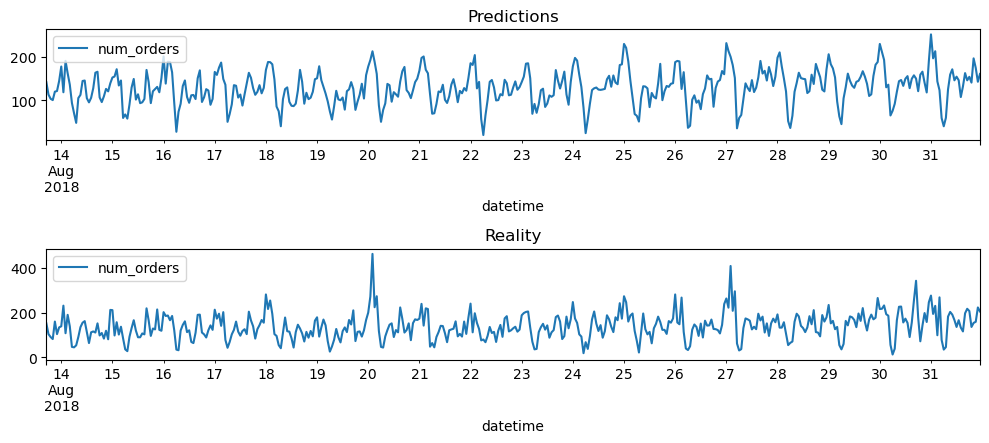

In [30]:
plt.figure(figsize=(10, 6))

plt.subplot(311)
predictions.plot(ax=plt.gca())
plt.title('Predictions')

plt.subplot(312)
y_test.plot(ax=plt.gca())
plt.title('Reality')

plt.tight_layout()

According to the results of the test on the test sample, the *LightGBM* model is the best in terms of both the value of the *RMSE* metric and the speed of operation presented in this study, on the test sample the *RMSE* metric indicator is ~42 and the block execution time is 160 ms.

## Conclusion

During the study, three machine learning models were trained, namely LightGBM, CatBoost and randomForest, after analyzing which the LightGBM model was selected, with indicators on the RMSE validation sample of ~32.9 (vs. 33.4 for CatBoost and 41.5 for randomForest), block execution time of 99 ms (vs. 314 ms for CatBoost and 558 ms for randomForest). The final indicators of the LightGBM model on the test sample were ~42 according to the RMSE quality metric, and the block execution time was 199 ms.


The following steps were taken:
- The dataset has been studied and analyzed.
- Revealed trend and seasonal indicators of the number of trips.
- New signs have been created.
- 3 machine learning models have been trained and analyzed.
- The best model in terms of quality and speed has been selected and tested.